### Code-2.3: PDE-NN for Non-Linear Convection - Burgers’ Equation (PDE)

Tasks:
    
    1. Problem setup:
        1.0. Data
        1.1. Geometry & BC
        1.2. Sampling plan
        1.3. PDE-NN 
    2. Optimize PDE-NN: [SGD]
    3. Visualize training dynamic

Purpose:

    1. Study PDE-NN flexibility 

Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pylab as plt 
from matplotlib import cm

import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

from IPython.display import clear_output
from time import time, gmtime, strftime, localtime

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from pyDOE import *
from scipy import pi, io

## run on CPU...
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable eager excution
tf.compat.v1.disable_eager_execution()

### 1. Problem setup

      
**Prior**

    1. Non-Linear Convection - Burgers’ equation: u(x, t)    , x∈[x_l, x_u], tx∈[0, T]
        - u_t + u*u_x = NU*u_xx
        - IC: - sin(pi*x)
        - BC: u(x_l, t) = u(x_u, t) = 0
       
    2. Constants (coefficients, spatial-temporal domain, etc):
        - NU = {0.1, 0.01, 0.01/pi}
        - h = 1

#### 1.0. Data

In [3]:
# Get exact solution from data folder
exact = io.loadmat(os.path.join('d01_burger', 'burgers_shock_nu1e-4_pi_num'))
exact['usol'].shape

(256, 100)

In [4]:
# spatial-temporal domain
T = exact['t'].max()

# computational boundary
x_l, x_u, t_l, t_u = exact['x'].min(), exact['x'].max(), 0, T
ext = [t_l, t_u, x_l, x_u]
ext

[0, 0.99, -1.0, 1.0]

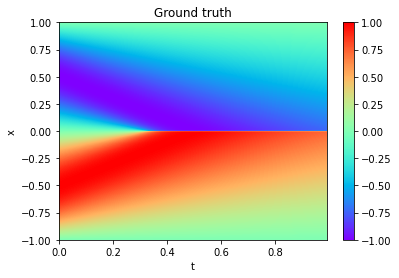

In [5]:
#fig = plt.figure(figsize=(15, 5))
un, ux = -1., 1.
_u = exact['usol']
plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, vmin=un, vmax=ux, aspect='auto');
plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('Ground truth');

#### 1.1. Geometry & BC

In [6]:
# PDE constant
#NU = 0.0
#NU = 0.01 / pi
#NU = 0.01 / pi
NU = 1e-4/pi

# IC 
def f_ic(x):
    u = - tf.math.sin( pi*x )
    return u.eval(session=tf.compat.v1.Session())

# vis IC
x = np.linspace(x_l, x_u, 5000)
#plt.plot(x, f_ic(x));

#### 1.2. Sampling plan

# PDE sample = 25600


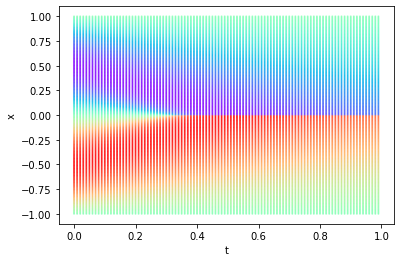

In [7]:
# training data
nx, nt = len(exact['x']), len(exact['t'])
mx, mt = np.meshgrid(exact['x'], exact['t'])
X_train = np.vstack([mt.flatten(), mx.flatten(), np.ones_like(mx.flatten())]).T
y_train = exact['usol'].T.reshape(-1 ,1)

print ('# PDE sample = %d' %len(y_train))

# visualize train data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.flatten(), marker='H', s=1, alpha=.5, cmap='rainbow');
plt.xlabel('t'); plt.ylabel('x');

In [8]:
#print(exact['x'],exact['t'])

# IC sample = 1000


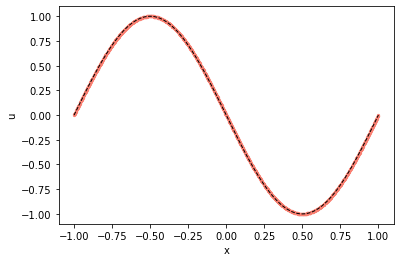

In [9]:
# IC data
n = 1000
x = np.linspace(x_l, x_u, n)
X_ic = np.hstack([np.zeros((n, 1)), x.reshape(-1, 1), np.ones((n, 1))])
y_ic = f_ic(x).reshape(-1, 1)

print ('# IC sample = %d' %len(y_ic))

# viz training data
plt.plot(x, f_ic(x), "k--", linewidth=1); plt.scatter(x, f_ic(x), c='salmon', alpha=1, s=5);
plt.xlabel('x'); plt.ylabel('u');

# BC sample = 1000


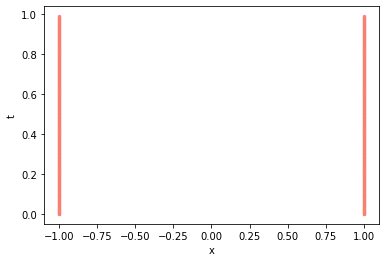

In [10]:
# BC data (n x2)
n = 500
t = np.linspace(t_l, t_u, n)
X_bc = np.vstack([np.hstack([t.reshape(-1, 1), x_l*np.ones((n, 1)), np.ones((n, 1))]),
                  np.hstack([t.reshape(-1, 1), x_u*np.ones((n, 1)), np.ones((n, 1))])])
y_bc = np.zeros((n*2, 1))

print ('# BC sample = %d' %len(y_bc))

# viz training data
plt.scatter(X_bc[:, 1], X_bc[:, 0], c='salmon', alpha=1, s=5); plt.xlabel('x'); plt.ylabel('t');

In [11]:
# PDE data (t * x)
X_pde, y_pde = X_train, y_train
print ('# PDE sample = %d' %len(y_pde))

# PDE sample = 25600


In [12]:
# evaluation data (t * x)
X_eval, y_eval = X_train, y_train
print ('# Evaluation sample = %d' %len(y_eval))

# Evaluation sample = 25600


In [13]:
# sampling plan generator
class SamplingPlan(keras.utils.Sequence):
    # sampling plan: data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(n_pde, n_ic, n_bc)
    def __init__(self, data=(), batch_size=(),
                 epochs=1000, n_split=10, batch_per_epoch=20):

        self.X, self.y, self.X_ic, self.y_ic, self.X_bc, self.y_bc = data
        self.n, self.n_ic, self.n_bc = len(self.X), len(self.X_ic), len(self.X_bc)
        self.ID, self.ID_ic, self.ID_bc = np.arange(self.n), np.arange(self.n_ic), np.arange(self.n_bc)
        # input parameters
        self.batch_size, self.batch_ic, self.batch_bc = batch_size
        self.batch_per_epoch = batch_per_epoch
        self.n_split = n_split
        self.epochs = epochs
        self._queues()
        # internal variables
        self.cur_epoch = 0
        self.cur_split = 0
        self.cur_IDs = np.array([], dtype=int)
        self.callback = False
        self.on_epoch_end()

    def __len__(self):
        # number of mini batch per epoch
        return self.batch_per_epoch

    def __getitem__(self, idx):
        # shuffle & pick batch_size sample
        np.random.shuffle(self.cur_IDs)
        idxs = self.cur_IDs[:self.batch_size]
        batch_X, batch_y = self.X[idxs], self.y[idxs]
        # pick ic sample
        np.random.shuffle(self.ID_ic)
        idxs = self.ID_ic[:self.batch_ic]
        batch_X_ic, batch_y_ic = self.X_ic[idxs], self.y_ic[idxs]
        # pick bc sample
        np.random.shuffle(self.ID_bc)
        idxs = self.ID_bc[:self.batch_bc]
        batch_X_bc, batch_y_bc = self.X_bc[idxs], self.y_bc[idxs]
        # to include ic & bc sample
        batch_X, batch_y = np.vstack([batch_X, batch_X_ic, batch_X_bc]), np.vstack([batch_y, batch_y_ic, batch_y_bc])
        return (batch_X, batch_y)

    def on_epoch_end(self):
        if self.cur_split < self.n_split:
            # check training loss criteria
            if self.callback:
                self._check_loss()
            # updates indexes after certain epoch
            if (self.cur_epoch == self.queue_epoch[self.cur_split]):
                self.cur_IDs = np.concatenate((self.cur_IDs, self.queue_n[self.cur_split]))
                self.cur_split += 1
                #print ('Increase sample size @epoch-%d: n = %d'%(self.cur_epoch+1, len(self.cur_IDs)))
                if self.callback:
                    # reset learning rate
                    self.lr_schedular._reset()
                    self.lr_monitor._reset()
            self.cur_epoch += 1

    def _queues(self):
        # decide when to increase sample & which
        self.queue_n = np.array_split(self.ID, self.n_split)
        self.queue_epoch = [a[0] for a in np.array_split(np.arange(self.epochs), self.n_split)]

    def _check_loss(self):
        if self.lr_monitor.fall_below:
            self.queue_epoch = [q - (self.queue_epoch[self.cur_split] - self.cur_epoch) if q >= self.queue_epoch[self.cur_split]
                                else q for q in self.queue_epoch]

    def lr_schedule(self, lr_schedular, lr_monitor):
        # lr schedule
        self.callback = True
        self.lr_schedular = lr_schedular
        self.lr_monitor = lr_monitor
        

#### 1.3. PDE-NN

In [14]:
#tf.keras.backend.set_floatx('float64')
tf.keras.backend.floatx()

'float32'

In [15]:
Luux_ind = 1
# specify PDE-NN model
def create_nn(ff, n_ffs, sigma, nodes, acf, lr_int):

    # input layers -> split into (t, x, z)
    inputs = layers.Input(shape=(3,))
    t, x, z = layers.Lambda( lambda k: tf.split(k, num_or_size_splits=3, axis=1))(inputs)

    # features mapping
    initializer_ff = tf.keras.initializers.TruncatedNormal(stddev=sigma)  # features initializer

    if (ff == 'RF'):
        hidden_f0 = layers.Dense(n_ffs, activation='linear', use_bias=False, trainable=False, kernel_initializer=initializer_ff)(layers.Concatenate()([t, x]))
        hidden_sin, hidden_cos = tf.math.sin(2*tf.constant(pi)*hidden_f0), tf.math.cos(2*tf.constant(pi)*hidden_f0)
        hidden_ff = layers.Concatenate()([hidden_sin, hidden_cos])

    if (ff == 'FF'):
        hidden_f0 = layers.Dense(n_ffs, activation='linear', use_bias=False, kernel_initializer=initializer_ff)(layers.Concatenate()([t, x]))
        hidden_sin, hidden_cos = tf.math.sin(2*tf.constant(pi)*hidden_f0), tf.math.cos(2*tf.constant(pi)*hidden_f0)
        hidden_ff = layers.Concatenate()([hidden_sin, hidden_cos])

    if (ff == 'SF') or (ff == 'SIREN'):
        hidden_f0 = layers.Dense(n_ffs*2, activation='linear', kernel_initializer=initializer_ff)(layers.Concatenate()([t, x]))
        hidden_ff = tf.math.sin(2*tf.constant(pi)*hidden_f0)

    if (ff == 'HF'):
        hidden_ff = layers.Dense(n_ffs*2, activation=acf, kernel_initializer=initializer_ff)(layers.Concatenate()([t, x]))

    # hidden layers
    if (ff == 'SIREN'):
        initializer = tf.keras.initializers.HeUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_2)
    else:
        initializer = tf.keras.initializers.GlorotUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_2)

    # output layers
    u = layers.Dense(1, use_bias=False, name="U")(hidden_l)
    
    # initiate model
    nn = models.Model(inputs=inputs, outputs=u)
    #nn = CustomModel(inputs=inputs, outputs=u)
    
    # axillary PDE outputs
    u_t, u_x = K.gradients(u, t)[0], K.gradients(u, x)[0]
    u_xx = K.gradients(u_x, x)[0]
    
    # PDE (1D Burgers equation) : u_t + u*u_x = NU*u_xx
    if Luux_ind == 0:
        pde = u_t + u*u_x - NU*u_xx
        pde1 = pde
    
    else:
        dx = 2/255
        dt = 1/100
        u_E = nn(tf.stack([t,x+dx,z],1))
        u_EE = nn(tf.stack([t,x+2.0*dx,z],1))
        u_W = nn(tf.stack([t,x-dx,z],1))
        u_WW = nn(tf.stack([t,x-2.0*dx,z],1))
        u_e = nn(tf.stack([t,x+0.5*dx,z],1))
        u_w = nn(tf.stack([t,x-0.5*dx,z],1))


#         u_E3 = nn(tf.stack([t,x+3.0*dx,z],1))
#         u_E4 = nn(tf.stack([t,x+4.0*dx,z],1))
#         u_E5 = nn(tf.stack([t,x+5.0*dx,z],1))
#         u_W3 = nn(tf.stack([t,x-3.0*dx,z],1))
#         u_W4 = nn(tf.stack([t,x-4.0*dx,z],1))
#         u_W5 = nn(tf.stack([t,x-5.0*dx,z],1))

    
        uc_e = u_e
        uc_w = u_w
        Luux = limit_uux(Luux_ind,dx, uc_e , uc_w , u , u_e , u_w , u_E , u_W , u_EE , u_WW)
        #Luux5 = limit_uux(5,dx, uc_e , uc_w , u , u_e , u_w , u_E , u_W , u_EE , u_WW)
        Luux1 = limit_uux(1,dx, uc_e , uc_w , u , u_e , u_w , u_E , u_W , u_EE , u_WW)
        #Luux = switch_ind*Luux1 + (1-switch_ind)*Luux5

        #pde = (u_t + Luux - NU*u_xx)
        pde = u_t + Luux - NU*(u_E-2*u+u_W)/(dx*dx)
        pde1 = u_t + Luux1 - NU*u_xx
        #pde1 = u_t + u*u_x - NU*u_xx
    
        #Luux = drp_6th(dx, dt,uc_e , uc_w , u , u_e , u_w , u_E , u_W , u_EE , u_WW, u_E3, u_W3 , u_E4, u_W4, u_E5, u_W5)

        
    #pde_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde), predictions=pde)
    #pde_mse = pde_mse
    
    # initial & boundary conditions:
    x_ic, u_ic = tf.boolean_mask(x, tf.equal(t, t_l)), tf.boolean_mask(u, tf.equal(t, t_l))
    ic_mse = tf.compat.v1.losses.mean_squared_error(labels=tf_ic(x_ic), predictions=u_ic)

    u_bc = tf.boolean_mask(u, tf.math.logical_or(tf.equal(x, x_l), tf.equal(x, x_u)))
    bc_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_bc), predictions=u_bc)

    #pde loss should only applied to inner domain, and not applied to boundary & initial condtions
    pde_bool = tf.math.logical_or(tf.not_equal(x, x_l), tf.not_equal(x, x_u))
    pde_bool = tf.math.logical_or(pde_bool,tf.not_equal(t, t_l))
    pde_inner = tf.boolean_mask(pde, pde_bool )
    pde_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde_inner), predictions=pde_inner)

    pde1_bool = tf.math.logical_or(tf.not_equal(x, x_l), tf.not_equal(x, x_u))
    pde1_bool = tf.math.logical_or(pde1_bool,tf.not_equal(t, t_l))
    pde1_inner = tf.boolean_mask(pde1, pde1_bool )
    pde1_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde1_inner), predictions=pde1_inner)

    ic_mse = ic_mse
    pde_mse = pde_mse
    bc_mse = bc_mse
    pde1_mse = pde1_mse
    # initiate model
    #nn = models.Model(inputs=inputs, outputs=u)    

    # optimizer
    optimizer = tf.keras.optimizers.Adam(lr_int)
    #optimizer = tf.keras.optimizers.RMSprop(lr_int)

    # compile model with [?] loss
    nn.compile(loss = compute_physics_loss(pde_mse, ic_mse, bc_mse),   
                optimizer = optimizer,
                metrics = [compute_data_loss(z),
                           compute_ic_loss(ic_mse), compute_bc_loss(bc_mse), compute_pde_loss(pde_mse)])      

    
    
    
#     nn.compile(loss = compute_data_loss(z),   
#                optimizer = optimizer,
#                metrics = [compute_data_loss(z),
#                           compute_ic_loss(ic_mse), compute_bc_loss(bc_mse), compute_pde_loss(pde_mse)])
    
    # pathway to NN inside variables
    insiders = [u, pde, pde_mse, ic_mse, bc_mse]
    eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function  
    
    return (nn, eval_ins, u, pde, pde_mse, ic_mse, bc_mse, optimizer, z, pde1, pde1_mse)
    #return (nn, eval_ins)

def tf_ic(x):
    u = - tf.math.sin( pi*x )
    return u

In [16]:
def drp_6th(dx, dt,uc_e , uc_w , u , u_e , u_w , u_E , u_W , u_EE , u_WW, u_E3, u_W3 , u_E4, u_W4, u_E5, u_W5):
#Luux_ind = 6, DRP-6th

    #for upwind, ue (i-4~i+3)
    #            uw (i-5~i+2)
    c1 = 0.00564910871217870
    c2 = -0.04156402784774520
    c3 = 0.14741955079779280
    c4 = -0.36135614119732720
    c5 =  0.85479080884410280
    c6 =  0.46773138077332480
    c7 =  -0.08166797117093120
    c8 =  0.00899729109195417

    Uwp = c1*u_W5 + c2*u_W4 + c3*u_W3 + c4*u_WW + c5*u_W + c6*u + c7*u_E + c8*u_EE
    Uep = c1*u_W4 + c2*u_W3 + c3*u_WW + c4*u_W + c5*u + c6*u_E + c7*u_EE + c8*u_E3
    
    #for downwind, ue (i-2~i+5)
    #              uw (i-3~i+4)
    b8 = c1
    b7 = c2
    b6 = c3
    b5 = c4
    b4 = c5
    b3 = c6
    b2 = c7
    b1 = c8
    
    Uwm = b1*u_W3 + b2*u_WW + b3*u_W + b4*u + b5*u_E + b6*u_EE + b7*u_E3 + b8*u_E4
    Uem = b1*u_WW + b2*u_W + b3*u + b4*u_E + b5*u_EE + b6*u_E3 + b7*u_E4 + b8*u_E5
    
    Ue = tf.where(tf.greater_equal(uc_e,0.0), Uep, Uem)
    Uw = tf.where(tf.greater_equal(uc_w,0.0), Uwp, Uwm)

    #UL LIMITER
    #for u_e                      uf         P        U        D
    CFL = abs(uc_e * dt / dx)
    Uep = FV_Phi_COMPUTE_UL_BAIR_TVD(CFL , Ue      , u      , u_W    , u_E)
    Uem = FV_Phi_COMPUTE_UL_BAIR_TVD(CFL , Ue      , u_E    , u_EE   , u)
    Ue = tf.where(tf.greater_equal(uc_e,0.0), Uep, Uem)
    
    
    #for u_w                      uf         p        U         D
    CFL = abs(uc_w * dt / dx)
    Uwp = FV_Phi_COMPUTE_UL_BAIR_TVD(CFL , Uw      , u_W    , u_WW    , u)
    Uwm = FV_Phi_COMPUTE_UL_BAIR_TVD(CFL , Uw      , u      , u_E     , u_W)
    Uw = tf.where(tf.greater_equal(uc_w,0.0), Uwp, Uwm)
    
    #compute uux
    uux = 0.5*(uc_e*Ue - uc_w*Uw)/dx
    
    return uux

In [17]:
def limit_uux(Luux_ind,dx, uc_e , uc_w , u , u_e , u_w , u_E , u_W , u_EE , u_WW):

    if Luux_ind == 1 :
        
#Luux_ind = 1, CUBISTA LIMITER
        #for u_e                     uf         P        U        D
        Uep = FV_Phi_COMPUTE_CUBISTA(u_e      , u      , u_W    , u_E)
        Uem = FV_Phi_COMPUTE_CUBISTA(u_e      , u_E    , u_EE   , u)
        Ue = tf.where(tf.greater_equal(uc_e,0.0), Uep, Uem)
    
    
        #for u_w                     uf         p        U         D
        Uwp = FV_Phi_COMPUTE_CUBISTA(u_w      , u_W    , u_WW    , u)
        Uwm = FV_Phi_COMPUTE_CUBISTA(u_w      , u      , u_E     , u_W)
        Uw = tf.where(tf.greater_equal(uc_w,0.0), Uwp, Uwm)
        
        #compute uux
        #uux = 0.5*(uc_e*Ue - uc_w*Uw)/dx
        uux = 0.5*(Ue*Ue - Uw*Uw)/dx
        return uux
    
    elif Luux_ind == 2 :
#Luux_ind = 2, QUICK SCHEME
        #for u_e
        Ue_p = 0.5*(u+u_E) - (u_W - 2.0*u   + u_E )*0.125
        Ue_m = 0.5*(u+u_E) - (u   - 2.0*u_E + u_EE)*0.125
        Ue = tf.where(tf.greater_equal(uc_e,0.0), Ue_p, Ue_m)
        #for u_w
        Uw_p = 0.5*(u+u_W) - (u_WW - 2.0*u_W + u  )*0.125
        Uw_m = 0.5*(u+u_W) - (u_W  - 2.0*u   + u_E)*0.125
        Uw = tf.where(tf.greater_equal(uc_w,0.0), Uw_p, Uw_m)

        uux = 0.5*(uc_e*Ue - uc_w*Uw)/dx
        return uux
    
    elif Luux_ind ==3 :
#Luux_ind = 3, central difference
        uux = 0.5*(uc_e*u_e - uc_w*u_w)/dx
        return uux
    
    elif Luux_ind ==4 :
#Luux_ind = 4, first-order upwind. FVM idea.
    #implement with tf.where
        Ue = tf.where(tf.greater_equal(uc_e, 0.0),u,u_E)
        Uw = tf.where(tf.greater_equal(uc_w, 0.0),u_W,u)
        uux = 0.5*(uc_e*Ue - uc_w*Uw)/dx
        return uux

    elif Luux_ind == 5 :
#Luux_ind = 5, first-order upwind. in this version uc is u
    #implement with tf.where
        uc = u
        f1 = uc*(u-u_W)/dx
        f2 = uc*(u_E-u)/dx
        uux = tf.where(tf.greater_equal(uc, 0.0), f1, f2)
        return uux
    
    elif Luux_ind == 6:
#HPUS LIMITER
        #for u_e                     uf         P        U        D
        #CFL = abs(uc_e * dt / dx)
        Uep = FV_Phi_COMPUTE_HPUS(u_e      , u      , u_W    , u_E)
        Uem = FV_Phi_COMPUTE_HPUS(u_e      , u_E    , u_EE   , u)
        Ue = tf.where(tf.greater_equal(uc_e,0.0), Uep, Uem)
    
    
        #for u_w                     uf         p        U         D
        #CFL = abs(uc_w * dt / dx)
        Uwp = FV_Phi_COMPUTE_HPUS(u_w      , u_W    , u_WW    , u)
        Uwm = FV_Phi_COMPUTE_HPUS(u_w      , u      , u_E     , u_W)
        Uw = tf.where(tf.greater_equal(uc_w,0.0), Uwp, Uwm)
    
        #compute uux
        uux = 0.5*(uc_e*Ue - uc_w*Uw)/dx
        return uux
    
#     else:
#         return 1e5
    else :
        uux = u*u_x
        return uux
    
# #UL LIMITER
#     #for u_e                      uf         P        U        D
#     CFL = abs(uc_e * dt / dx)
#     Uep = FV_Phi_COMPUTE_UL(CFL , Ue      , u      , u_W    , u_E)
#     Uem = FV_Phi_COMPUTE_UL(CFL , Ue      , u_E    , u_EE   , u)
#     Ue = tf.where(tf.greater_equal(uc_e,0.0), Uep, Uem)
    
    
#     #for u_w                      uf         p        U         D
#     CFL = abs(uc_w * dt / dx)
#     Uwp = FV_Phi_COMPUTE_UL(CFL , Uw      , u_W    , u_WW    , u)
#     Uwm = FV_Phi_COMPUTE_UL(CFL , Uw      , u      , u_E     , u_W)
#     Uw = tf.where(tf.greater_equal(uc_w,0.0), Uwp, Uwm)
    
#     #compute uux
#     uux = 0.5*(uc_e*Ue - uc_w*Uw)/dx


def FV_Phi_COMPUTE_HPUS(Phi_f , Phi_P , Phi_U , Phi_D):
    EPS = 1.0e-12
    DEL = Phi_D - Phi_U

    #if DEL == 0: DEL = EPS
    #else : DEL no change
    #this step is to avoid DEL_1 become NAN
    outside_bool = tf.equal(tf.sign(DEL),0.0)
    inside_bool = tf.logical_not(outside_bool) 
    DEL = tf.where(inside_bool, DEL, EPS)
    DEL_1 = 1.0 / DEL

    phi_p_hat = (Phi_P - Phi_U)*DEL_1

    #outside the region: phi_f_hat = phi_p_hat
    phi_f_hat = phi_p_hat

    
    #region 1: 0 < phi_p_hat < 1.0 --> phi_f_hat = -4*phi_p_hat^4 + 10*phi_p_hat^3 - 8*phi_p_hat^2 + phi_p_hat + 2
    reg1 = 0.0
    reg2 = 1.0
    reg_f_hat = -4.0*tf.pow(phi_p_hat,4) + 10.0*tf.pow(phi_p_hat,3) - 8.0*tf.pow(phi_p_hat,2) + phi_p_hat + 2.0
    
    reg1_bool = tf.greater(phi_p_hat,reg1)
    reg2_bool = tf.less(phi_p_hat,reg2)
    reg_bool = tf.logical_and(reg1_bool,reg2_bool)

    phi_f_hat = tf.where(reg_bool, reg_f_hat, phi_f_hat)
    
    Phi_f_NEW = phi_f_hat*DEL + Phi_U

    Phi_f_NEW = tf.where(outside_bool, Phi_P, Phi_f_NEW)
    
    return Phi_f_NEW

def FV_Phi_COMPUTE_CUBISTA(Phi_f , Phi_P , Phi_U , Phi_D):
    EPS = 1.0e-12
    DEL = Phi_D - Phi_U

    #if DEL == 0: DEL = EPS
    #else : DEL no change
    #this step is to avoid DEL_1 become NAN
    outside_bool = tf.equal(tf.sign(DEL),0.0)
    inside_bool = tf.logical_not(outside_bool) 
    DEL = tf.where(inside_bool, DEL, EPS)
    DEL_1 = 1.0 / DEL

    phi_p_hat = (Phi_P - Phi_U)*DEL_1

    #outside the region: phi_f_hat = phi_p_hat
    phi_f_hat = phi_p_hat

    
    #region 1: 0 < phi_p_hat < 3/8 ---> phi_f_hat = 7/4*phi_p_hat
    reg1 = 0.0
    reg2 = 3.0/8.0
    reg_f_hat = 7.0/4.0*phi_p_hat
    
    reg1_bool = tf.greater(phi_p_hat,reg1)
    reg2_bool = tf.less(phi_p_hat,reg2)
    reg_bool = tf.logical_and(reg1_bool,reg2_bool)

    phi_f_hat = tf.where(reg_bool, reg_f_hat, phi_f_hat)
    
    #region 2: 3/8 <= phi_p_hat <= 3/4 ---> phi_f_hat = 3/4*phi_p_hat + 3/8
    reg1 = 3.0/8.0
    reg2 = 3.0/4.0
    reg_f_hat = 3.0/4.0*phi_p_hat + 3.0/8.0
    
    reg1_bool = tf.greater_equal(phi_p_hat,reg1)
    reg2_bool = tf.less_equal(phi_p_hat,reg2)
    reg_bool = tf.logical_and(reg1_bool,reg2_bool)

    
    phi_f_hat = tf.where(reg_bool, reg_f_hat, phi_f_hat)
    
    #region 3: 3/4 < phi_p_hat < 1 ---> phi_f_hat = 1/4*phi_p_hat + 3/4
    reg1 = 3.0/4.0
    reg2 = 1.0
    reg_f_hat = 1.0/4.0*phi_p_hat + 3.0/4.0
    
    reg1_bool = tf.greater(phi_p_hat,reg1)
    reg2_bool = tf.less(phi_p_hat,reg2)
    reg_bool = tf.logical_and(reg1_bool,reg2_bool)

    
    phi_f_hat = tf.where(reg_bool, reg_f_hat, phi_f_hat)
    
    Phi_f_NEW = phi_f_hat*DEL + Phi_U

    Phi_f_NEW = tf.where(outside_bool, Phi_P, Phi_f_NEW)
    
    return Phi_f_NEW



def FV_Phi_COMPUTE_UL(CFL, Phi_f , Phi_P , Phi_U , Phi_D):
    
    EPS = 1.0e-12
    DEL = Phi_D - Phi_U

    #if DEL == 0: DEL = EPS
    #else : DEL no change
    #this step is to avoid DEL_1 become NAN
    outside_bool = tf.equal(tf.sign(DEL),0.0)
    inside_bool = tf.logical_not(outside_bool) 
    DEL = tf.where(inside_bool, DEL, EPS)
    DEL_1 = 1.0 / DEL

    phi_p_hat = (Phi_P - Phi_U) * DEL_1
    #outside the region: Phi_P


#for NVD constraint
    reg1 = 0.0
    reg2 = 1.0
    
    reg1_bool = tf.greater(phi_p_hat,reg1)
    reg2_bool = tf.less(phi_p_hat,reg2)
    reg_bool = tf.logical_and(reg1_bool,reg2_bool)
    
    Phi_f_NEW = tf.where(reg_bool, Phi_f, Phi_P)
    Phi_f_NEW = tf.where(outside_bool, Phi_P, Phi_f_NEW)
    
    return Phi_f_NEW



def FV_Phi_COMPUTE_UL_BAIR_TVD(CFL, Phi_f , Phi_P , Phi_U , Phi_D):
    
    EPS = 1.0e-12
    DEL = Phi_D - Phi_U
    C   = CFL

    DEL_1 = 1.0 / (DEL+EPS)



#for NVD constraint
    phi_p_hat = (Phi_P - Phi_U) * DEL_1
    Phi_f_NEW = Phi_f
    
    #if phi_p_hat < 0.0 : Phi_f_NEW = Phi_P
    #else : Phi_f_NEW no change
    f1 = Phi_f
    Phi_f_NEW = tf.where(tf.less(phi_p_hat,0.0), Phi_P, f1)
    
    #if phi_p_hat > 1.0 : Phi_f_NEW = Phi_P
    #else : Phi_f_NEW no change
    f2 = Phi_f_NEW
    Phi_f_NEW = tf.where(tf.greater(phi_p_hat,1.0), Phi_P, f2)

    #BAIR constraint...
    #if phi_p_hat < 0.5 : phi_min_BAIR = 1.5*phi_p_hat, phi_max_BAIR = 0.5*(phi_p_hat + 1.0)
    #else : phi_min_BAIR = 0.5*(phi_p_hat + 1.0), phi_max_BAIR = MIN(1.5*phi_p_hat , 1.0)
    phi_min_BAIR_1 = 1.5*phi_p_hat
    phi_max_BAIR_1 = 0.5*(phi_p_hat + 1.0)
    phi_min_BAIR_2 = 0.5*(phi_p_hat + 1.0)
    phi_max_BAIR_2 = tf.minimum(1.5*phi_p_hat , 1.0)
    
    phi_min_BAIR = tf.where(tf.less(phi_p_hat,0.5), phi_min_BAIR_1, phi_min_BAIR_2)
    phi_max_BAIR = tf.where(tf.less(phi_p_hat,0.5), phi_max_BAIR_1, phi_max_BAIR_2)

    phi_f_hat = (Phi_f - Phi_U) * DEL_1
    
    #if phi_f_hat < phi_min_BAIR : Phi_f_NEW = phi_min_BAIR*DEL + Phi_U
    #else : Phi_f_NEW no change
    Phi_f_NEW_min_BAIR = phi_min_BAIR*DEL + Phi_U
    f3 = Phi_f_NEW
    Phi_f_NEW = tf.where(tf.less(phi_f_hat,phi_min_BAIR), Phi_f_NEW_min_BAIR, f3)

    f4 = phi_f_hat
    phi_f_hat = tf.where(tf.less(phi_f_hat,phi_min_BAIR), phi_min_BAIR, f4)
    
    #if phi_f_hat > phi_max_BAIR : Phi_f_NEW = phi_max_BAIR*DEL + Phi_U
    #else : Phi_f_NEW no change
    Phi_f_NEW_max_BAIR = phi_max_BAIR*DEL + Phi_U
    f5 = Phi_f_NEW
    Phi_f_NEW = tf.where(tf.greater(phi_f_hat,phi_max_BAIR), Phi_f_NEW_max_BAIR, f5)
    
    f6 = phi_f_hat
    phi_f_hat = tf.where(tf.greater(phi_f_hat,phi_max_BAIR), phi_max_BAIR, f6)
    
#for CFL constraint
#     #phi_f_hat = (Phi_f - Phi_U) * DEL_1

#     #TVD constraint...
#     #if phi_p_hat < 0.5 : phi_max = (2.0 - C)*phi_p_hat
#     #else : phi_max = 1.0_DP - C*(1.0 - phi_p_hat)
#     phi_max_TVD1 = (2.0 - C)*phi_p_hat
#     phi_max_TVD2 = 1.0 - C*(1.0 - phi_p_hat)
#     phi_max = tf.where(tf.less(phi_p_hat,0.5), phi_max_TVD1, phi_max_TVD2)
    
#     phi_max = tf.minimum(phi_max , 1.0)
#     phi_min = phi_p_hat

#     #if phi_f_hat > phi_max: Phi_f_NEW = phi_max*DEL + Phi_U
#     #else : Phi_f_NEW no change
#     Phi_f_max = phi_max*DEL + Phi_U
#     f7 = Phi_f_NEW
#     Phi_f_NEW = tf.where(tf.greater(phi_f_hat,phi_max), Phi_f_max, f7)
    
#     #if phi_f_hat < phi_min : Phi_f_NEW = Phi_P
#     #else : Phi_f_NEW no change
#     f8 = Phi_f_NEW
#     Phi_f_NEW = tf.where(tf.less(phi_f_hat,phi_min), Phi_P, f8)
    
#for very small DEL value, use upwind
    # if abs(DEL) <= EPS : Phi_f_NEW = Phi_P
    # else : Phi_f_NEW no change
    f9 = Phi_f_NEW
    Phi_f_NEW = tf.where(tf.less_equal(abs(DEL),EPS), Phi_P, f9)
    
    return Phi_f_NEW

In [18]:
# define loss function (data loss)
def compute_data_loss(z):
    def data_loss(y_true, y_pred):
        labels = tf.equal(z, 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))
    return data_loss

# define loss function (Physics loss)
def compute_physics_loss(pde_mse, ic_mse, bc_mse):
    def physics_loss(y_true, y_pred): return pde_mse + ic_mse + bc_mse
    return physics_loss # return a function 

def compute_ic_bc_loss(ic_mse, bc_mse):
    def ic_bc_loss(y_true, y_pred): return ic_mse + bc_mse
    return ic_bc_loss # return a function 

# define loss function (BC loss)
def compute_bc_loss(bc_mse):
    def bc_loss(y_true, y_pred): return bc_mse
    return bc_loss # return a function 

# define loss function (IC loss)
def compute_ic_loss(ic_mse):
    def ic_loss(y_true, y_pred): return ic_mse
    return ic_loss # return a function

# define loss function (PDE loss)
def compute_pde_loss(pde_mse):
    def pde_loss(y_true, y_pred): return pde_mse
    return pde_loss # return a function 


# callback: stop training if reach certain criteria (loss value)
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=1e-5, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping given %s= %.1e" %(epoch, self.monitor, self.value))
            self.model.stop_training = True
            
# callback: prediction history           
class PredictionHistory(Callback):
    def __init__(self, eval_ins, train_data):
        super(Callback, self).__init__()
        self.train_data = train_data
        self.eval_ins = eval_ins
        self.e_hist = []
        self.u_hist = []
        self.r_hist = []
        self.pde_mse_hist = []
        self.ic_mse_hist = []
        self.bc_mse_hist = []
    def on_epoch_end(self, epoch, logs={}):
        e = epoch + 1
        if (e < 10) | ((e < 100) & (e%10 == 0)) | ((e < 1000) & (e%100 == 0)) | (e%1000 == 0):
            X_train = self.train_data
            u, r, pde_mse, ic_mse, bc_mse = self.eval_ins(X_train)
            self.e_hist.append(e)
            self.u_hist.append(u)
            self.r_hist.append(r)
            self.pde_mse_hist.append(pde_mse)
            self.ic_mse_hist.append(ic_mse)
            self.bc_mse_hist.append(bc_mse)
        
        
# callback: weights history           
class WeightsHistory(Callback):
    def __init__(self):
        super(Callback, self).__init__()
        self.w_hist = []
    def on_epoch_end(self, epoch, logs={}):
        ws = np.array([])
        for _w in self.model.get_weights() : ws = np.append(ws, _w.flatten())
        self.w_hist.append(ws)

In [19]:
class SwitchScheme(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 500:
            nn.compile(loss = compute_physics_loss(nn_pde1_mse, nn_ic_mse, nn_bc_mse),   
                       optimizer = nn_optimizer,
                       metrics = [compute_data_loss(nn_z),
                       compute_ic_loss(nn_ic_mse), compute_bc_loss(nn_bc_mse), compute_pde_loss(nn_pde1_mse)])      
    
            # pathway to NN inside variables
            insiders = [nn_u, nn_pde1, nn_pde1_mse, nn_ic_mse, nn_bc_mse]
            eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function
            K.set_value(nn.optimizer.lr, lr*0.5)
            print('epoch end  , scheme = ', 1)

#         if epoch < 500 and epoch % 100 == 0:
#             new_pde_mse = epoch/500*nn_pde1_mse + (500-epoch)/500*nn_pde_mse
#             nn.compile(loss = compute_physics_loss(new_pde_mse, nn_ic_mse, nn_bc_mse),   
#                     optimizer = nn_optimizer,
#                     metrics = [compute_data_loss(nn_z),
#                     compute_ic_loss(nn_ic_mse), compute_bc_loss(nn_bc_mse), compute_pde_loss(new_pde_mse)])      
    
#             # pathway to NN inside variables
#             insiders = [nn_u, nn_pde1, new_pde_mse, nn_ic_mse, nn_bc_mse]
#             eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function
#             #K.set_value(nn.optimizer.lr, lr)
#             #print('epoch end  , scheme = ', 1)            
#         elif epoch == 500:
#             new_pde_mse = nn_pde1_mse
#             nn.compile(loss = compute_physics_loss(new_pde_mse, nn_ic_mse, nn_bc_mse),   
#                     optimizer = nn_optimizer,
#                     metrics = [compute_data_loss(nn_z),
#                     compute_ic_loss(nn_ic_mse), compute_bc_loss(nn_bc_mse), compute_pde_loss(new_pde_mse)])      
    
#             # pathway to NN inside variables
#             insiders = [nn_u, nn_pde1, new_pde_mse, nn_ic_mse, nn_bc_mse]
#             eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function
#             #K.set_value(nn.optimizer.lr, lr)
#             #print('epoch end  , scheme = ', 1)


In [20]:
# learning rate & loss monitor
class MonitorLossAndLR(Callback):
    def __init__(self, monitor='loss', target_loss=1e-3, patience=10, base_lr=5e-2):
        super(MonitorLossAndLR, self).__init__()
        self.target_loss = target_loss
        self.patience = patience
        self.monitor = monitor
        self.base_lr = base_lr
        self.wait = 0
        self.fall_below = False
        self.restore_lr = False
    def _reset(self):
        self.restore_lr = True
        self.fall_below = False
        self.wait = 0
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_loss = logs.get(self.monitor)
        if self.restore_lr:
            K.set_value(self.model.optimizer.lr, self.base_lr)
            self.restore_lr = False
        elif (current_loss < self.target_loss):
            self.wait += 1
        if (self.wait >= self.patience):
            self.fall_below = True

### 2. Optimize D-PDE-NN: [SGD]

In [21]:
#CUSTOM MODEL
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # We can change the default convention for parameters (tuple x, y and weights)
        # and use any data we want.
        x, y = data

        # In the following code, we use compiled loss, metrics and optimizer.
        # This is mandatory! You are free to experiment.
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        
        
        gradients = tape.gradient(loss, self.trainable_variables)
        gradients_relax = gradients
        self.optimizer.apply_gradients(zip(gradients_relax, self.trainable_variables))

        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)

        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

In [22]:
# initiate NN model (& pathway to internal values)
# number of ff_features (m) and input dimensions (d)
n_ffs = m = 32
d = 2

n_nodes = 20
acf = 'tanh'
ff = 'HF'
sigma = 1.0
#nn, eval_ins = create_nn(ff, n_ffs, sigma, n_nodes, acf, lr_int = 0.001)

(nn, eval_ins, nn_u, nn_pde, nn_pde_mse, nn_ic_mse, nn_bc_mse, nn_optimizer, nn_z, nn_pde1, nn_pde1_mse) = create_nn(ff, n_ffs, sigma, n_nodes, acf, lr_int = 0.001)

# first pass
u_0, r_0, pde_mse_0, ic_mse_0, bc_mse_0 = eval_ins(X_eval)

nn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 1), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           lambda[0][0]                     
                                                                 lambda[0][1]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           192         concatenate[0][0]            

In [23]:
# training setting: EPOCH & learning rate 
EPOCH = 1000
lr = 5e-3
#lr = 0.01

# set learning rate
K.set_value(nn.optimizer.lr, lr)

# callback setting
lr_sched = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=1e-6)
hi_pred = PredictionHistory(eval_ins, X_eval)
NPDE_scheme = SwitchScheme()
#callbacks_list = [lr_sched, hi_pred,NPDE_scheme]
callbacks_list = [lr_sched, hi_pred] 


# time it
t0 = time()

# train model
dataGenerator = SamplingPlan(data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(512, 16, 16),
                             epochs=EPOCH, n_split=1, batch_per_epoch=200)
history = nn.fit(dataGenerator, epochs=EPOCH, verbose=2, callbacks=callbacks_list)
print ("...\nRunning time: %d mins %d secs!" %(int(time()-t0)/60, np.remainder(int(time()-t0), 60)))

Epoch 1/1000
200/200 - 8s - loss: 0.2024 - data_loss: 0.1375 - ic_loss: 0.1175 - bc_loss: 0.0239 - pde_loss: 0.0610
Epoch 2/1000
200/200 - 1s - loss: 0.1255 - data_loss: 0.0941 - ic_loss: 0.0704 - bc_loss: 0.0048 - pde_loss: 0.0502
Epoch 3/1000
200/200 - 1s - loss: 0.1116 - data_loss: 0.0855 - ic_loss: 0.0632 - bc_loss: 0.0030 - pde_loss: 0.0454
Epoch 4/1000
200/200 - 1s - loss: 0.1046 - data_loss: 0.0826 - ic_loss: 0.0606 - bc_loss: 0.0022 - pde_loss: 0.0417
Epoch 5/1000
200/200 - 1s - loss: 0.0993 - data_loss: 0.0793 - ic_loss: 0.0587 - bc_loss: 0.0016 - pde_loss: 0.0390
Epoch 6/1000
200/200 - 1s - loss: 0.0941 - data_loss: 0.0817 - ic_loss: 0.0571 - bc_loss: 0.0012 - pde_loss: 0.0358
Epoch 7/1000
200/200 - 1s - loss: 0.0923 - data_loss: 0.0797 - ic_loss: 0.0563 - bc_loss: 9.3445e-04 - pde_loss: 0.0351
Epoch 8/1000
200/200 - 1s - loss: 0.0916 - data_loss: 0.0802 - ic_loss: 0.0561 - bc_loss: 0.0015 - pde_loss: 0.0339
Epoch 9/1000
200/200 - 1s - loss: 0.0918 - data_loss: 0.0790 - ic_lo

Epoch 70/1000
200/200 - 1s - loss: 0.0891 - data_loss: 0.0762 - ic_loss: 0.0565 - bc_loss: 2.7605e-04 - pde_loss: 0.0323
Epoch 71/1000
200/200 - 1s - loss: 0.1103 - data_loss: 0.1020 - ic_loss: 0.0694 - bc_loss: 0.0014 - pde_loss: 0.0396
Epoch 72/1000
200/200 - 1s - loss: 0.1051 - data_loss: 0.0891 - ic_loss: 0.0646 - bc_loss: 3.9205e-04 - pde_loss: 0.0401
Epoch 73/1000
200/200 - 1s - loss: 0.0923 - data_loss: 0.0831 - ic_loss: 0.0571 - bc_loss: 2.2167e-04 - pde_loss: 0.0350
Epoch 74/1000
200/200 - 1s - loss: 0.0912 - data_loss: 0.0827 - ic_loss: 0.0577 - bc_loss: 3.8514e-04 - pde_loss: 0.0331
Epoch 75/1000
200/200 - 1s - loss: 0.0902 - data_loss: 0.0769 - ic_loss: 0.0584 - bc_loss: 5.7521e-04 - pde_loss: 0.0313
Epoch 76/1000
200/200 - 1s - loss: 0.1036 - data_loss: 0.0799 - ic_loss: 0.0641 - bc_loss: 0.0017 - pde_loss: 0.0378
Epoch 77/1000
200/200 - 1s - loss: 0.0954 - data_loss: 0.0833 - ic_loss: 0.0602 - bc_loss: 2.6113e-04 - pde_loss: 0.0350
Epoch 78/1000
200/200 - 1s - loss: 0.091

Epoch 138/1000
200/200 - 1s - loss: 0.0374 - data_loss: 0.0812 - ic_loss: 0.0168 - bc_loss: 1.7378e-04 - pde_loss: 0.0204
Epoch 139/1000
200/200 - 1s - loss: 0.0229 - data_loss: 0.0753 - ic_loss: 0.0135 - bc_loss: 9.0377e-05 - pde_loss: 0.0093
Epoch 140/1000
200/200 - 1s - loss: 0.0338 - data_loss: 0.0771 - ic_loss: 0.0143 - bc_loss: 2.7753e-04 - pde_loss: 0.0192
Epoch 141/1000
200/200 - 1s - loss: 0.0279 - data_loss: 0.0748 - ic_loss: 0.0129 - bc_loss: 1.3224e-04 - pde_loss: 0.0149
Epoch 142/1000
200/200 - 1s - loss: 0.0236 - data_loss: 0.0746 - ic_loss: 0.0129 - bc_loss: 8.4434e-05 - pde_loss: 0.0105
Epoch 143/1000
200/200 - 1s - loss: 0.0200 - data_loss: 0.0755 - ic_loss: 0.0117 - bc_loss: 6.3440e-05 - pde_loss: 0.0083
Epoch 144/1000
200/200 - 1s - loss: 0.0348 - data_loss: 0.0694 - ic_loss: 0.0126 - bc_loss: 2.6426e-04 - pde_loss: 0.0220
Epoch 145/1000
200/200 - 1s - loss: 0.0347 - data_loss: 0.0312 - ic_loss: 0.0098 - bc_loss: 4.8046e-04 - pde_loss: 0.0244
Epoch 146/1000
200/200 -

Epoch 206/1000
200/200 - 1s - loss: 0.0543 - data_loss: 0.0342 - ic_loss: 0.0159 - bc_loss: 0.0014 - pde_loss: 0.0370
Epoch 207/1000
200/200 - 1s - loss: 0.0310 - data_loss: 0.0517 - ic_loss: 0.0186 - bc_loss: 1.1222e-04 - pde_loss: 0.0123
Epoch 208/1000
200/200 - 1s - loss: 0.0211 - data_loss: 0.0528 - ic_loss: 0.0138 - bc_loss: 6.4075e-05 - pde_loss: 0.0072
Epoch 209/1000
200/200 - 1s - loss: 0.0158 - data_loss: 0.0510 - ic_loss: 0.0101 - bc_loss: 2.6095e-05 - pde_loss: 0.0057
Epoch 210/1000
200/200 - 1s - loss: 0.0127 - data_loss: 0.0513 - ic_loss: 0.0077 - bc_loss: 2.2736e-05 - pde_loss: 0.0050
Epoch 211/1000
200/200 - 1s - loss: 0.0123 - data_loss: 0.0514 - ic_loss: 0.0069 - bc_loss: 2.9952e-05 - pde_loss: 0.0055
Epoch 212/1000
200/200 - 1s - loss: 0.0132 - data_loss: 0.0537 - ic_loss: 0.0064 - bc_loss: 7.2154e-05 - pde_loss: 0.0068
Epoch 213/1000
200/200 - 1s - loss: 0.0104 - data_loss: 0.0524 - ic_loss: 0.0060 - bc_loss: 2.9516e-05 - pde_loss: 0.0043
Epoch 214/1000
200/200 - 1s 

Epoch 274/1000
200/200 - 1s - loss: 0.0031 - data_loss: 0.0103 - ic_loss: 9.9183e-04 - bc_loss: 2.1542e-05 - pde_loss: 0.0021
Epoch 275/1000
200/200 - 1s - loss: 0.0133 - data_loss: 0.0112 - ic_loss: 0.0020 - bc_loss: 2.1272e-04 - pde_loss: 0.0111
Epoch 276/1000
200/200 - 1s - loss: 0.0054 - data_loss: 0.0106 - ic_loss: 0.0016 - bc_loss: 4.1540e-05 - pde_loss: 0.0038
Epoch 277/1000
200/200 - 1s - loss: 0.0054 - data_loss: 0.0096 - ic_loss: 0.0012 - bc_loss: 4.3251e-05 - pde_loss: 0.0041
Epoch 278/1000
200/200 - 1s - loss: 0.0033 - data_loss: 0.0104 - ic_loss: 0.0010 - bc_loss: 2.2536e-05 - pde_loss: 0.0023
Epoch 279/1000
200/200 - 1s - loss: 0.0141 - data_loss: 0.0110 - ic_loss: 0.0019 - bc_loss: 1.7495e-04 - pde_loss: 0.0120
Epoch 280/1000
200/200 - 1s - loss: 0.0054 - data_loss: 0.0112 - ic_loss: 0.0018 - bc_loss: 3.8675e-05 - pde_loss: 0.0036
Epoch 281/1000
200/200 - 1s - loss: 0.0137 - data_loss: 0.0106 - ic_loss: 0.0017 - bc_loss: 1.3895e-04 - pde_loss: 0.0119
Epoch 282/1000
200/2

Epoch 341/1000
200/200 - 1s - loss: 0.0021 - data_loss: 0.0027 - ic_loss: 4.6204e-04 - bc_loss: 1.4452e-05 - pde_loss: 0.0017
Epoch 342/1000
200/200 - 1s - loss: 0.0019 - data_loss: 0.0027 - ic_loss: 4.3037e-04 - bc_loss: 9.7801e-06 - pde_loss: 0.0015
Epoch 343/1000
200/200 - 1s - loss: 0.0100 - data_loss: 0.0061 - ic_loss: 0.0011 - bc_loss: 1.5253e-04 - pde_loss: 0.0087
Epoch 344/1000
200/200 - 1s - loss: 0.0017 - data_loss: 0.0116 - ic_loss: 6.5437e-04 - bc_loss: 7.9699e-06 - pde_loss: 0.0011
Epoch 345/1000
200/200 - 1s - loss: 0.0022 - data_loss: 0.0096 - ic_loss: 6.1463e-04 - bc_loss: 1.5454e-05 - pde_loss: 0.0016
Epoch 346/1000
200/200 - 1s - loss: 0.0074 - data_loss: 0.0112 - ic_loss: 9.4208e-04 - bc_loss: 8.8735e-05 - pde_loss: 0.0064
Epoch 347/1000
200/200 - 1s - loss: 0.0080 - data_loss: 0.0106 - ic_loss: 0.0010 - bc_loss: 1.2078e-04 - pde_loss: 0.0068
Epoch 348/1000
200/200 - 1s - loss: 0.0050 - data_loss: 0.0104 - ic_loss: 8.5120e-04 - bc_loss: 5.5515e-05 - pde_loss: 0.0041


Epoch 407/1000
200/200 - 1s - loss: 0.0056 - data_loss: 0.0179 - ic_loss: 0.0012 - bc_loss: 7.2388e-05 - pde_loss: 0.0043
Epoch 408/1000
200/200 - 1s - loss: 0.0034 - data_loss: 0.0185 - ic_loss: 0.0011 - bc_loss: 3.7981e-05 - pde_loss: 0.0023
Epoch 409/1000
200/200 - 1s - loss: 0.0020 - data_loss: 0.0188 - ic_loss: 9.1456e-04 - bc_loss: 1.2640e-05 - pde_loss: 0.0011
Epoch 410/1000
200/200 - 1s - loss: 0.0039 - data_loss: 0.0180 - ic_loss: 0.0010 - bc_loss: 4.4117e-05 - pde_loss: 0.0029
Epoch 411/1000
200/200 - 1s - loss: 0.0062 - data_loss: 0.0176 - ic_loss: 0.0012 - bc_loss: 8.0707e-05 - pde_loss: 0.0049
Epoch 412/1000
200/200 - 1s - loss: 0.0034 - data_loss: 0.0189 - ic_loss: 0.0010 - bc_loss: 2.2831e-05 - pde_loss: 0.0024
Epoch 413/1000
200/200 - 1s - loss: 0.0184 - data_loss: 0.0188 - ic_loss: 0.0021 - bc_loss: 2.9593e-04 - pde_loss: 0.0161
Epoch 414/1000
200/200 - 1s - loss: 0.0191 - data_loss: 0.0053 - ic_loss: 0.0032 - bc_loss: 1.6777e-04 - pde_loss: 0.0157
Epoch 415/1000
200/2

Epoch 471/1000
200/200 - 1s - loss: 6.4421e-04 - data_loss: 0.0019 - ic_loss: 1.9096e-04 - bc_loss: 3.4150e-06 - pde_loss: 4.4984e-04
Epoch 472/1000
200/200 - 1s - loss: 5.2403e-04 - data_loss: 0.0016 - ic_loss: 1.3280e-04 - bc_loss: 1.9462e-06 - pde_loss: 3.8929e-04
Epoch 473/1000
200/200 - 1s - loss: 0.0015 - data_loss: 0.0018 - ic_loss: 1.5228e-04 - bc_loss: 1.5412e-05 - pde_loss: 0.0013
Epoch 474/1000
200/200 - 1s - loss: 8.4916e-04 - data_loss: 0.0017 - ic_loss: 1.3739e-04 - bc_loss: 6.3487e-06 - pde_loss: 7.0542e-04
Epoch 475/1000
200/200 - 1s - loss: 5.0727e-04 - data_loss: 0.0016 - ic_loss: 1.1415e-04 - bc_loss: 2.0421e-06 - pde_loss: 3.9108e-04
Epoch 476/1000
200/200 - 1s - loss: 0.0047 - data_loss: 0.0019 - ic_loss: 2.4358e-04 - bc_loss: 5.0903e-05 - pde_loss: 0.0044
Epoch 477/1000
200/200 - 1s - loss: 0.0010 - data_loss: 0.0017 - ic_loss: 1.5952e-04 - bc_loss: 1.3599e-05 - pde_loss: 8.4909e-04
Epoch 478/1000
200/200 - 1s - loss: 6.1606e-04 - data_loss: 0.0017 - ic_loss: 1.18

Epoch 533/1000
200/200 - 1s - loss: 8.0663e-04 - data_loss: 8.0784e-05 - ic_loss: 9.0423e-05 - bc_loss: 4.4121e-06 - pde_loss: 7.1180e-04
Epoch 534/1000
200/200 - 1s - loss: 6.0126e-04 - data_loss: 6.8826e-05 - ic_loss: 7.6048e-05 - bc_loss: 2.0326e-06 - pde_loss: 5.2318e-04
Epoch 535/1000
200/200 - 1s - loss: 9.3529e-04 - data_loss: 7.6979e-05 - ic_loss: 8.7563e-05 - bc_loss: 6.6495e-06 - pde_loss: 8.4108e-04
Epoch 536/1000
200/200 - 1s - loss: 9.4939e-04 - data_loss: 7.5780e-05 - ic_loss: 8.2379e-05 - bc_loss: 6.0477e-06 - pde_loss: 8.6096e-04
Epoch 537/1000
200/200 - 1s - loss: 7.4437e-04 - data_loss: 6.6484e-05 - ic_loss: 7.4441e-05 - bc_loss: 3.4064e-06 - pde_loss: 6.6653e-04
Epoch 538/1000
200/200 - 1s - loss: 5.6334e-04 - data_loss: 6.3674e-05 - ic_loss: 7.3101e-05 - bc_loss: 2.0445e-06 - pde_loss: 4.8820e-04
Epoch 539/1000
200/200 - 1s - loss: 8.6381e-04 - data_loss: 7.1104e-05 - ic_loss: 8.3080e-05 - bc_loss: 4.9943e-06 - pde_loss: 7.7574e-04
Epoch 540/1000
200/200 - 1s - loss

Epoch 593/1000
200/200 - 1s - loss: 4.1103e-04 - data_loss: 5.1857e-05 - ic_loss: 5.3531e-05 - bc_loss: 1.1285e-06 - pde_loss: 3.5637e-04
Epoch 594/1000
200/200 - 1s - loss: 5.1753e-04 - data_loss: 5.2483e-05 - ic_loss: 5.3499e-05 - bc_loss: 2.3023e-06 - pde_loss: 4.6173e-04
Epoch 595/1000
200/200 - 1s - loss: 5.2806e-04 - data_loss: 5.2665e-05 - ic_loss: 5.9063e-05 - bc_loss: 2.2839e-06 - pde_loss: 4.6671e-04
Epoch 596/1000
200/200 - 1s - loss: 3.7112e-04 - data_loss: 4.9994e-05 - ic_loss: 5.1371e-05 - bc_loss: 8.5745e-07 - pde_loss: 3.1890e-04
Epoch 597/1000
200/200 - 1s - loss: 5.9625e-04 - data_loss: 5.4675e-05 - ic_loss: 5.5807e-05 - bc_loss: 2.5859e-06 - pde_loss: 5.3786e-04
Epoch 598/1000
200/200 - 1s - loss: 3.6854e-04 - data_loss: 4.9879e-05 - ic_loss: 5.3121e-05 - bc_loss: 6.6631e-07 - pde_loss: 3.1475e-04
Epoch 599/1000
200/200 - 1s - loss: 3.8354e-04 - data_loss: 5.0268e-05 - ic_loss: 5.3702e-05 - bc_loss: 9.6222e-07 - pde_loss: 3.2888e-04
Epoch 600/1000
200/200 - 1s - loss

Epoch 653/1000
200/200 - 1s - loss: 3.0567e-04 - data_loss: 4.3428e-05 - ic_loss: 4.5903e-05 - bc_loss: 3.9069e-07 - pde_loss: 2.5938e-04
Epoch 654/1000
200/200 - 1s - loss: 3.1467e-04 - data_loss: 4.6130e-05 - ic_loss: 4.6321e-05 - bc_loss: 7.0820e-07 - pde_loss: 2.6764e-04
Epoch 655/1000
200/200 - 1s - loss: 3.1455e-04 - data_loss: 4.3838e-05 - ic_loss: 4.7075e-05 - bc_loss: 6.0148e-07 - pde_loss: 2.6687e-04
Epoch 656/1000
200/200 - 1s - loss: 3.4427e-04 - data_loss: 4.4097e-05 - ic_loss: 4.5754e-05 - bc_loss: 1.0633e-06 - pde_loss: 2.9746e-04
Epoch 657/1000
200/200 - 1s - loss: 3.1572e-04 - data_loss: 4.4153e-05 - ic_loss: 4.4060e-05 - bc_loss: 6.4319e-07 - pde_loss: 2.7101e-04
Epoch 658/1000
200/200 - 1s - loss: 2.9048e-04 - data_loss: 4.4698e-05 - ic_loss: 4.5104e-05 - bc_loss: 5.1386e-07 - pde_loss: 2.4486e-04
Epoch 659/1000
200/200 - 1s - loss: 3.3669e-04 - data_loss: 4.5448e-05 - ic_loss: 4.7103e-05 - bc_loss: 7.4635e-07 - pde_loss: 2.8884e-04
Epoch 660/1000
200/200 - 1s - loss

Epoch 713/1000
200/200 - 1s - loss: 2.5115e-04 - data_loss: 4.2313e-05 - ic_loss: 4.1520e-05 - bc_loss: 1.7620e-07 - pde_loss: 2.0945e-04
Epoch 714/1000
200/200 - 1s - loss: 2.4751e-04 - data_loss: 4.1844e-05 - ic_loss: 4.0525e-05 - bc_loss: 2.1338e-07 - pde_loss: 2.0677e-04
Epoch 715/1000
200/200 - 1s - loss: 2.6719e-04 - data_loss: 4.3399e-05 - ic_loss: 4.1307e-05 - bc_loss: 1.9275e-07 - pde_loss: 2.2570e-04
Epoch 716/1000
200/200 - 1s - loss: 2.6018e-04 - data_loss: 4.2147e-05 - ic_loss: 4.1557e-05 - bc_loss: 2.0296e-07 - pde_loss: 2.1842e-04
Epoch 717/1000
200/200 - 1s - loss: 2.4956e-04 - data_loss: 4.1976e-05 - ic_loss: 3.9578e-05 - bc_loss: 2.1890e-07 - pde_loss: 2.0976e-04
Epoch 718/1000
200/200 - 1s - loss: 2.6572e-04 - data_loss: 4.1900e-05 - ic_loss: 4.2565e-05 - bc_loss: 2.0843e-07 - pde_loss: 2.2295e-04
Epoch 719/1000
200/200 - 1s - loss: 2.6557e-04 - data_loss: 4.2865e-05 - ic_loss: 4.0402e-05 - bc_loss: 1.8296e-07 - pde_loss: 2.2498e-04
Epoch 720/1000
200/200 - 1s - loss

Epoch 773/1000
200/200 - 1s - loss: 2.5560e-04 - data_loss: 4.1304e-05 - ic_loss: 4.0837e-05 - bc_loss: 1.6403e-07 - pde_loss: 2.1460e-04
Epoch 774/1000
200/200 - 1s - loss: 2.4875e-04 - data_loss: 3.8871e-05 - ic_loss: 4.0570e-05 - bc_loss: 1.6539e-07 - pde_loss: 2.0801e-04
Epoch 775/1000
200/200 - 1s - loss: 2.4575e-04 - data_loss: 3.9663e-05 - ic_loss: 3.9531e-05 - bc_loss: 1.4851e-07 - pde_loss: 2.0607e-04
Epoch 776/1000
200/200 - 1s - loss: 2.4610e-04 - data_loss: 4.0169e-05 - ic_loss: 4.0929e-05 - bc_loss: 1.4617e-07 - pde_loss: 2.0503e-04
Epoch 777/1000
200/200 - 1s - loss: 2.4895e-04 - data_loss: 4.0876e-05 - ic_loss: 3.8751e-05 - bc_loss: 1.6653e-07 - pde_loss: 2.1003e-04
Epoch 778/1000
200/200 - 1s - loss: 2.5017e-04 - data_loss: 4.1414e-05 - ic_loss: 3.7408e-05 - bc_loss: 1.8541e-07 - pde_loss: 2.1258e-04
Epoch 779/1000
200/200 - 1s - loss: 2.4803e-04 - data_loss: 4.2319e-05 - ic_loss: 4.0177e-05 - bc_loss: 1.5814e-07 - pde_loss: 2.0770e-04
Epoch 780/1000
200/200 - 1s - loss

Epoch 833/1000
200/200 - 1s - loss: 2.3088e-04 - data_loss: 4.0864e-05 - ic_loss: 3.8048e-05 - bc_loss: 1.2652e-07 - pde_loss: 1.9270e-04
Epoch 834/1000
200/200 - 1s - loss: 2.4238e-04 - data_loss: 4.0180e-05 - ic_loss: 3.8195e-05 - bc_loss: 1.2500e-07 - pde_loss: 2.0406e-04
Epoch 835/1000
200/200 - 1s - loss: 2.3819e-04 - data_loss: 3.9999e-05 - ic_loss: 3.7390e-05 - bc_loss: 1.5722e-07 - pde_loss: 2.0064e-04
Epoch 836/1000
200/200 - 1s - loss: 2.4242e-04 - data_loss: 4.1199e-05 - ic_loss: 3.7714e-05 - bc_loss: 1.5122e-07 - pde_loss: 2.0456e-04
Epoch 837/1000
200/200 - 1s - loss: 2.3820e-04 - data_loss: 4.0799e-05 - ic_loss: 3.8121e-05 - bc_loss: 1.2851e-07 - pde_loss: 1.9995e-04
Epoch 838/1000
200/200 - 1s - loss: 2.3886e-04 - data_loss: 3.9549e-05 - ic_loss: 3.8025e-05 - bc_loss: 1.4167e-07 - pde_loss: 2.0069e-04
Epoch 839/1000
200/200 - 1s - loss: 2.3779e-04 - data_loss: 3.9158e-05 - ic_loss: 3.7843e-05 - bc_loss: 1.5802e-07 - pde_loss: 1.9978e-04
Epoch 840/1000
200/200 - 1s - loss

Epoch 893/1000
200/200 - 1s - loss: 2.4273e-04 - data_loss: 4.0791e-05 - ic_loss: 3.8204e-05 - bc_loss: 1.2460e-07 - pde_loss: 2.0440e-04
Epoch 894/1000
200/200 - 1s - loss: 2.3888e-04 - data_loss: 4.0319e-05 - ic_loss: 3.7933e-05 - bc_loss: 1.1398e-07 - pde_loss: 2.0083e-04
Epoch 895/1000
200/200 - 1s - loss: 2.4199e-04 - data_loss: 4.1141e-05 - ic_loss: 3.9040e-05 - bc_loss: 1.0606e-07 - pde_loss: 2.0284e-04
Epoch 896/1000
200/200 - 1s - loss: 2.3596e-04 - data_loss: 3.8340e-05 - ic_loss: 3.7102e-05 - bc_loss: 1.4010e-07 - pde_loss: 1.9872e-04
Epoch 897/1000
200/200 - 1s - loss: 2.4383e-04 - data_loss: 3.9024e-05 - ic_loss: 3.8800e-05 - bc_loss: 1.1858e-07 - pde_loss: 2.0491e-04
Epoch 898/1000
200/200 - 1s - loss: 2.3883e-04 - data_loss: 4.1394e-05 - ic_loss: 3.7118e-05 - bc_loss: 1.2543e-07 - pde_loss: 2.0158e-04
Epoch 899/1000
200/200 - 1s - loss: 2.2908e-04 - data_loss: 3.9317e-05 - ic_loss: 3.7798e-05 - bc_loss: 1.3279e-07 - pde_loss: 1.9115e-04
Epoch 900/1000
200/200 - 1s - loss

Epoch 953/1000
200/200 - 1s - loss: 2.3089e-04 - data_loss: 3.8646e-05 - ic_loss: 3.8894e-05 - bc_loss: 1.2099e-07 - pde_loss: 1.9187e-04
Epoch 954/1000
200/200 - 1s - loss: 2.3846e-04 - data_loss: 3.8786e-05 - ic_loss: 3.6654e-05 - bc_loss: 1.1763e-07 - pde_loss: 2.0169e-04
Epoch 955/1000
200/200 - 1s - loss: 2.4001e-04 - data_loss: 4.0308e-05 - ic_loss: 3.7358e-05 - bc_loss: 1.2843e-07 - pde_loss: 2.0253e-04
Epoch 956/1000
200/200 - 1s - loss: 2.4259e-04 - data_loss: 4.0224e-05 - ic_loss: 3.8697e-05 - bc_loss: 1.4101e-07 - pde_loss: 2.0375e-04
Epoch 957/1000
200/200 - 1s - loss: 2.3601e-04 - data_loss: 3.8901e-05 - ic_loss: 3.7290e-05 - bc_loss: 1.1733e-07 - pde_loss: 1.9860e-04
Epoch 958/1000
200/200 - 1s - loss: 2.3384e-04 - data_loss: 3.9904e-05 - ic_loss: 3.7645e-05 - bc_loss: 1.2869e-07 - pde_loss: 1.9606e-04
Epoch 959/1000
200/200 - 1s - loss: 2.3909e-04 - data_loss: 3.9835e-05 - ic_loss: 3.9233e-05 - bc_loss: 1.4904e-07 - pde_loss: 1.9971e-04
Epoch 960/1000
200/200 - 1s - loss

In [24]:
# final loss
name_checkpt = 'EPOCH = %05d  LOSS = %.2e   (DATA = %.2e, IC = %.2e, BC = %.2e, PDE = %.2e)'%(EPOCH, history.history['loss'][-1],
                history.history['data_loss'][-1], history.history['ic_loss'][-1], history.history['bc_loss'][-1],
                history.history['pde_loss'][-1])
print (name_checkpt)

EPOCH = 01000  LOSS = 2.37e-04   (DATA = 4.24e-05, IC = 3.66e-05, BC = 1.37e-07, PDE = 2.00e-04)


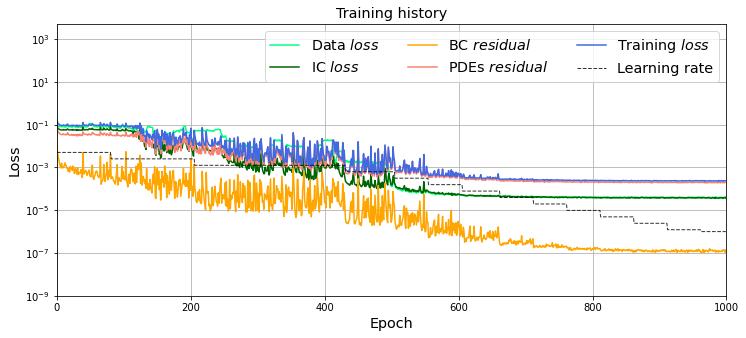

In [25]:
# plot loss history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.plot(hist['epoch'], hist['data_loss'], label=r'Data $loss$', alpha=1, c='springgreen');
plt.plot(hist['epoch'], hist['ic_loss'], label=r'IC $loss$', alpha=1, c='darkgreen');
plt.plot(hist['epoch'], hist['bc_loss'], label=r'BC $residual$', alpha=1, c='orange');
plt.plot(hist['epoch'], hist['pde_loss'], label=r'PDEs $residual$', alpha=1, c='salmon');
plt.plot(hist['epoch'], hist['loss'], label=r'Training $loss$', alpha=1, c='royalblue'); plt.yscale('log'); plt.grid();
plt.plot(hist['epoch'], hist['lr'], "k--", label=r'Learning rate', alpha=.8, linewidth=1);
plt.xlabel('Epoch', size='x-large'); plt.ylabel('Loss', size='x-large'); plt.xlim((0, EPOCH)); plt.ylim((1e-9, 5e3));
plt.title(r'Training history', fontsize="x-large"); plt.legend(fontsize='x-large', ncol=3);

mse ic = 3.680e-05
mse u  = 4.034e-05


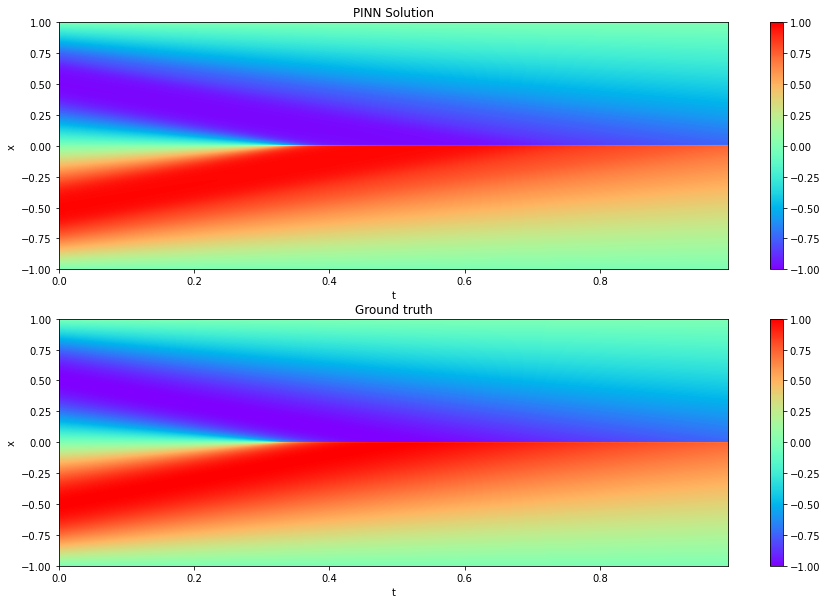

In [26]:
# new prediction & error on [train] data
e_u, e_r, _, _, _ = eval_ins(X_train)

# residuals
idx = (X_train[:, 0] == 0)
mse_ic = np.mean((e_u[idx].flatten() - y_train[idx].flatten())**2)
mse_u = np.mean((e_u.flatten() - y_train.flatten())**2)
print ('mse ic = %.3e' %mse_ic)
print ('mse u  = %.3e' %mse_u)

# plot IC
fig = plt.figure(figsize=(15, 10))
un, ux = -1, 1
ax = plt.subplot(2, 1, 1)
_u = e_u.reshape(nt, nx).T
plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, vmin=un, vmax=ux, aspect='auto');
plt.colorbar(); plt.xlabel('t'); plt.ylabel('x');plt.title('PINN Solution');
ax = plt.subplot(2, 1, 2)
_u = exact['usol']
plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, vmin=un, vmax=ux, aspect='auto');
plt.colorbar(); plt.xlabel('t'); plt.ylabel('x'); plt.title('Ground truth');

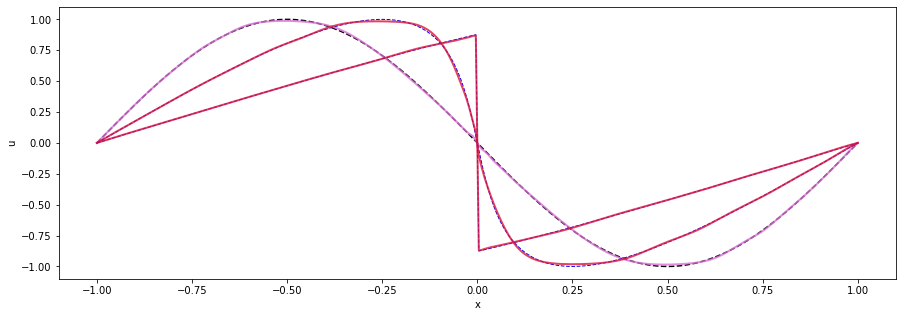

In [27]:
# time evolution
fig = plt.figure(figsize=(15, 5))
plt.plot(x, f_ic(x), "k--"); plt.ylabel('u'); plt.xlabel('x'); 
idx = (X_train[:, 0] == 0)
_x, _y = X_train[idx, 1], e_u[idx,]
plt.plot(_x, _y, c='orchid', alpha=.8, linewidth=2);
for t in [0.25,0.75]:
    idx = (X_train[:, 0] == t)
    _x, _y = X_train[idx, 1], e_u[idx]
    plt.plot(_x, y_train[idx], 'b--', alpha=1, linewidth=1, linestyle='--');
    plt.plot(_x, _y, c='crimson', alpha=.8, linewidth=2);

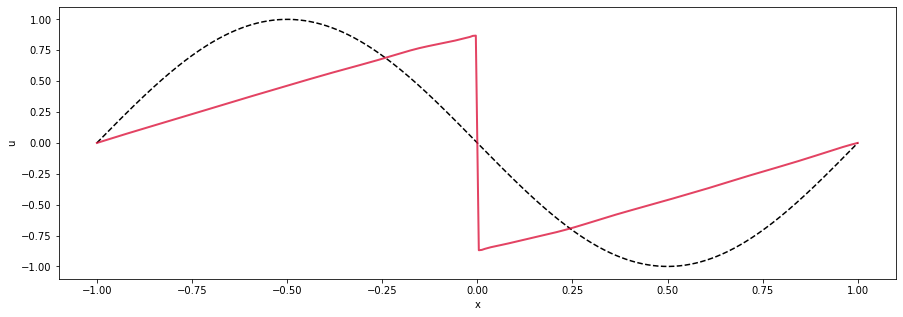

In [28]:
# time evolution
fig = plt.figure(figsize=(15, 5))
plt.plot(x, f_ic(x), "k--"); plt.ylabel('u'); plt.xlabel('x'); 
idx = (X_train[:, 0] == 0)
_x, _y = X_train[idx, 1], e_u[idx,]
#plt.plot(_x, _y, c='orchid', alpha=.8, linewidth=2);
for t in [0.75]:
    idx = (X_train[:, 0] == t)
    _x, _y = X_train[idx, 1], e_u[idx]
    #plt.plot(_x, y_train[idx], 'b--', alpha=1, linewidth=1, linestyle='--');
    plt.plot(_x, _y, c='crimson', alpha=.8, linewidth=2);

### 3. Visualize training dynamic

In [29]:
# prediction history
u_hist = np.vstack([np.array([u_0]), np.array(hi_pred.u_hist)])[:,:,0]
e_hist = np.array([0] + hi_pred.e_hist)

# choose epoches to viz
eps = [0, 1, 2, 5, 10, 20, 50, 100, 1000]

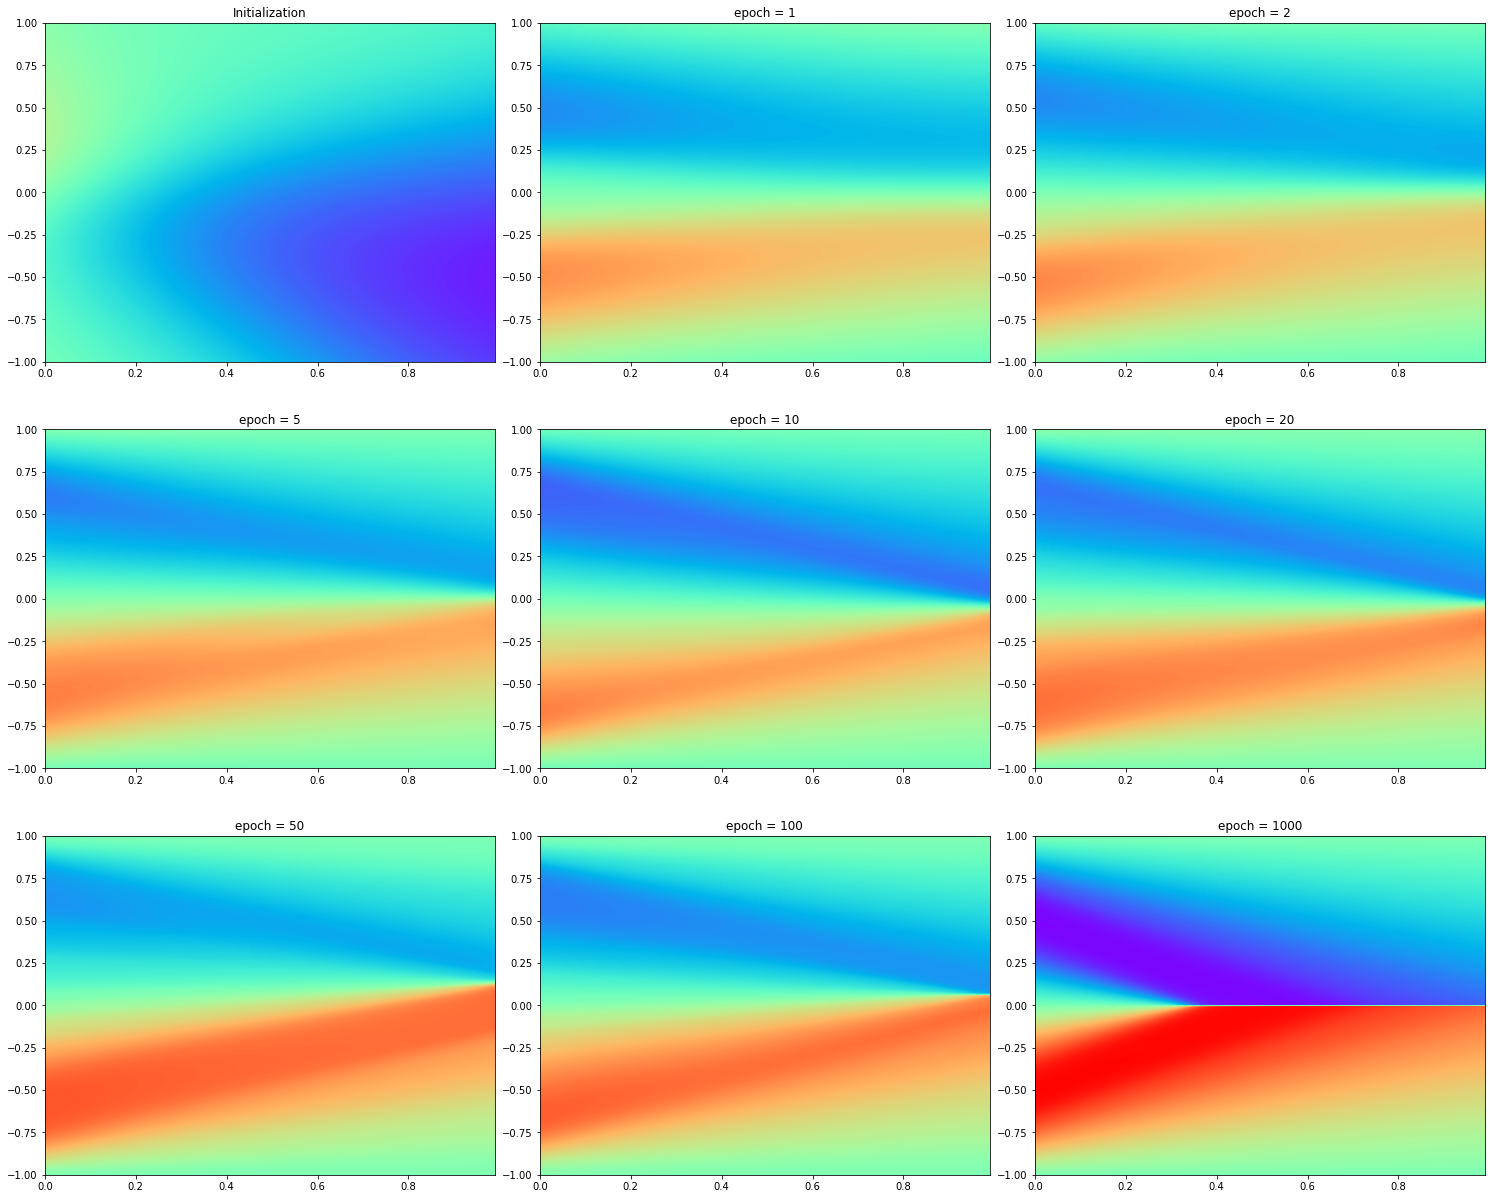

In [30]:
# training dynamic (solution)

dyn_u = u_hist.copy()
un, ux = -1, 1


fig = plt.figure(figsize=(20, 16))
plt.subplots_adjust(bottom=0, left=0, top=1, right=1, wspace=.1);

# u @initialization
ax = plt.subplot(3, 3, 1)
_u = dyn_u[0].reshape(100, 256).T
plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext,
           vmin=un, vmax=ux, aspect='auto'); plt.title('Initialization');

# u @various epoches
for i in range(1, 9):
    ax = plt.subplot(3, 3, 1+i)
    idx = (e_hist == eps[i]); 
    _u = dyn_u[idx].reshape(100, 256).T
    plt.imshow(_u, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext,
               vmin=un, vmax=ux, aspect='auto'); plt.title('epoch = %d' %(eps[i]));

In [31]:
# Luux_index = 1
# ii = 1
# #for final EPOCH and histroy loss information
# filename = "scheme_"+str(Luux_index)+"_"+str(ii)+".txt"
# f = open('C:/Python/pinn/JC/runrun/'+filename, 'w')
# f.write('nx= 256, dt = 0.01\n')
# f.write(name_checkpt+"\n")
# f.write('mse ic = %e\n' %mse_ic)
# f.write('mse u  = %e\n' %mse_u)
# r0 = 'EPOCH'
# r1 = 'loss'
# r2 = 'ic_loss'
# r3 = 'bc_loss'
# r4 = 'pde_loss'
# r5 = 'lr'
# f.write(r0+"  "+r1+"  "+r2+"  "+r3+"  "+r4+"  "+r5)

# f.close()

# #output time-history loss
# filename = "scheme_"+str(Luux_index)+"_"+str(ii)+"_history.txt"
# f = open('C:/Python/pinn/JC/runrun/'+filename, 'w')
# for ee in range(0,EPOCH) :
#     f.write('%4d  %e  %e  %e  %e  %e\n' %(ee+1,hist[r1].get(ee),hist[r2].get(ee),hist[r3].get(ee),hist[r4].get(ee),hist[r5].get(ee)  ) )
# f.close()

# #output final results for t=0 to t=0.99
# for t_i in range(0,100):
#     t = t_i*0.01
#     filename = "scheme_"+str(Luux_index)+"_"+str(ii)+"_time_"+str(t_i)+"_.txt"

#     idx = (X_train[:, 0] == t)
#     _x, _y = X_train[idx, 1], e_u[idx]
#     f = open('C:/Python/pinn/JC/runrun/'+filename, 'w')
#     for ee in range(0,256):
#         f.write('%e  %e\n' %(_x[ee], _y[ee]))

#     f.close()